## Imports

In [96]:
import numpy as np
import pandas as pd

import scipy
from scipy.io import arff
from scipy import stats
import joblib

# scipy.optimize

In [97]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split, StratifiedKFold, cross_validate, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

## Load Data

In [100]:
data = arff.loadarff('seismic-bumps.arff')

In [101]:
df = pd.DataFrame(data[0])

In [102]:
df.shape

(2584, 19)

In [103]:
df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,b'a',b'a',b'N',15180.0,48.0,-72.0,-72.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
1,b'a',b'a',b'N',14720.0,33.0,-70.0,-79.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,b'0'
2,b'a',b'a',b'N',8050.0,30.0,-81.0,-78.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
3,b'a',b'a',b'N',28820.0,171.0,-23.0,40.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,b'0'
4,b'a',b'a',b'N',12640.0,57.0,-63.0,-52.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'


In [104]:
df.columns

Index(['seismic', 'seismoacoustic', 'shift', 'genergy', 'gpuls', 'gdenergy',
       'gdpuls', 'ghazard', 'nbumps', 'nbumps2', 'nbumps3', 'nbumps4',
       'nbumps5', 'nbumps6', 'nbumps7', 'nbumps89', 'energy', 'maxenergy',
       'class'],
      dtype='object')

## Data Preprocessing

### Categorizing columns in types of features and labels

In [105]:
label = 'class'
col_list_categorical = ['seismic', 'seismoacoustic', 'shift', 'ghazard']
col_list_numerical = ['genergy', 'gpuls', 'gdenergy', 'gdpuls', 'energy', 'maxenergy']
col_list_discrete = ['nbumps', 'nbumps2', 'nbumps3', 'nbumps4', 'nbumps5', 'nbumps6', 'nbumps7', 'nbumps89']
len([label]) + len(col_list_categorical) + len(col_list_discrete) + len(col_list_numerical)

19

### Decoding bytes to utf-8

In [106]:
for col in df.columns:
    if col in col_list_categorical + [label]:
        df[col] = df[col].str.decode("utf-8")
        if col == label:
            print(df[col].value_counts())
            df[col] = df[col].astype(int)

0    2414
1     170
Name: class, dtype: int64


In [107]:
df.dtypes

seismic            object
seismoacoustic     object
shift              object
genergy           float64
gpuls             float64
gdenergy          float64
gdpuls            float64
ghazard            object
nbumps            float64
nbumps2           float64
nbumps3           float64
nbumps4           float64
nbumps5           float64
nbumps6           float64
nbumps7           float64
nbumps89          float64
energy            float64
maxenergy         float64
class               int32
dtype: object

In [108]:
df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,15180.0,48.0,-72.0,-72.0,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,a,a,N,14720.0,33.0,-70.0,-79.0,a,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,0
2,a,a,N,8050.0,30.0,-81.0,-78.0,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,a,a,N,28820.0,171.0,-23.0,40.0,a,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,0
4,a,a,N,12640.0,57.0,-63.0,-52.0,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [109]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2584 entries, 0 to 2583
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   seismic         2584 non-null   object 
 1   seismoacoustic  2584 non-null   object 
 2   shift           2584 non-null   object 
 3   genergy         2584 non-null   float64
 4   gpuls           2584 non-null   float64
 5   gdenergy        2584 non-null   float64
 6   gdpuls          2584 non-null   float64
 7   ghazard         2584 non-null   object 
 8   nbumps          2584 non-null   float64
 9   nbumps2         2584 non-null   float64
 10  nbumps3         2584 non-null   float64
 11  nbumps4         2584 non-null   float64
 12  nbumps5         2584 non-null   float64
 13  nbumps6         2584 non-null   float64
 14  nbumps7         2584 non-null   float64
 15  nbumps89        2584 non-null   float64
 16  energy          2584 non-null   float64
 17  maxenergy       2584 non-null   f

In [110]:
df.describe()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
count,2.584000e+03,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.0,2584.0,2584.0,2584.000000,2584.000000,2584.000000
mean,9.024252e+04,538.579334,12.375774,4.508901,0.859520,0.393576,0.392802,0.067724,0.004644,0.0,0.0,0.0,4975.270898,4278.850619,0.065789
std,2.292005e+05,562.652536,80.319051,63.166556,1.364616,0.783772,0.769710,0.279059,0.068001,0.0,0.0,0.0,20450.833222,19357.454882,0.247962
min,1.000000e+02,2.000000,-96.000000,-96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,1.166000e+04,190.000000,-37.000000,-36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
50%,2.548500e+04,379.000000,-6.000000,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
75%,5.283250e+04,669.000000,38.000000,30.250000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,2600.000000,2000.000000,0.000000
max,2.595650e+06,4518.000000,1245.000000,838.000000,9.000000,8.000000,7.000000,3.000000,1.000000,0.0,0.0,0.0,402000.000000,400000.000000,1.000000


In [111]:
df.columns

Index(['seismic', 'seismoacoustic', 'shift', 'genergy', 'gpuls', 'gdenergy',
       'gdpuls', 'ghazard', 'nbumps', 'nbumps2', 'nbumps3', 'nbumps4',
       'nbumps5', 'nbumps6', 'nbumps7', 'nbumps89', 'energy', 'maxenergy',
       'class'],
      dtype='object')

In [112]:
# Dataframe Checkpoint
df_raw = df.copy(deep=True)

### Target Distributions Check

In [113]:
df['class'].value_counts() * 100 /len(df['class']) 

0    93.421053
1     6.578947
Name: class, dtype: float64

(None, None)

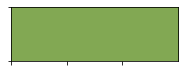

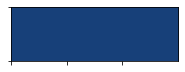

In [114]:
colors = sns.color_palette([sns.color_palette("gist_earth_r")[2], sns.color_palette("gist_earth_r")[5]])
# The colors are:
sns.palplot(sns.color_palette("gist_earth_r")[2]), sns.palplot(sns.color_palette("gist_earth_r")[5])

Text(0, 0.5, 'COUNT')

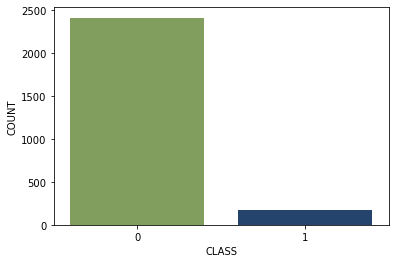

In [115]:
sns.countplot(x=label, data=df, palette=colors)
plt.xlabel('CLASS')
plt.ylabel('COUNT')

### Categorical Feature Encoding

#### Categorical Variables Distributions

In [116]:
for col in col_list_categorical:
    print(df[col].value_counts())

a    1682
b     902
Name: seismic, dtype: int64
a    1580
b     956
c      48
Name: seismoacoustic, dtype: int64
W    1663
N     921
Name: shift, dtype: int64
a    2342
b     212
c      30
Name: ghazard, dtype: int64


#### Contingency tables for categorical variables

In [117]:
df.seismic.value_counts()

a    1682
b     902
Name: seismic, dtype: int64

In [118]:
data_crosstab = pd.crosstab(df['seismic'], df[label], colnames=['class'])
data_crosstab

class,0,1
seismic,,
a,1599,83
b,815,87


Larger fraction in (b | 1)

In [119]:
data_crosstab = pd.crosstab(df['seismoacoustic'], df[label], colnames=['class'])
data_crosstab

class,0,1
seismoacoustic,,
a,1479,101
b,890,66
c,45,3


In [120]:
101/1479 , 66/890

(0.068289384719405, 0.07415730337078652)

Not much bias

In [121]:
data_crosstab = pd.crosstab(df['shift'], df[label])
data_crosstab

class,0,1
shift,,
N,904,17
W,1510,153


In [122]:
17/904 , 153/1510

(0.018805309734513276, 0.10132450331125828)

10% of the (W | 0) is 1.

In [123]:
data_crosstab = pd.crosstab(df['ghazard'], df[label])
data_crosstab

class,0,1
ghazard,,
a,2186,156
b,198,14
c,30,0


In [124]:
2186/156, 198/14

(14.012820512820513, 14.142857142857142)

Similar ratios

#### One-hot encoder

In [125]:
def one_hot_encoder(col_name, df):
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder(drop='first', sparse=False)
    try:
        encoded_array = label_encoder.fit_transform(df[col_name])
#         SKLEARN IMPLEMENTATION
        encoded_array_reshaped = encoded_array.reshape(len(encoded_array), 1)
        one_hot_encoded_array = onehot_encoder.fit_transform(encoded_array_reshaped)
#         one_hot_encoded_array = to_categorical(encoded_array)
        print(one_hot_encoded_array)
        num_features = one_hot_encoded_array.shape[1]
        print("Number of encoded columns to add: ", num_features)
        new_enc_col_names = [col + '_enc_' + str(num) for num in range(0, num_features)] 
        df_enc = pd.DataFrame(one_hot_encoded_array)
        print("Shape of encoded df: ", df_enc.shape)
        df_enc.columns = new_enc_col_names
        print("New column names: ", new_enc_col_names)
        df = pd.concat([df, df_enc], axis=1)
        df.drop(columns=col, inplace=True)
        return df
    except Exception as e:
        print(e)
        print("Error in encoding feature : " + col_name)

In [126]:
for col in col_list_categorical:
    df = one_hot_encoder(col, df)
df.shape

[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]]
Number of encoded columns to add:  1
Shape of encoded df:  (2584, 1)
New column names:  ['seismic_enc_0']
[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
Number of encoded columns to add:  2
Shape of encoded df:  (2584, 2)
New column names:  ['seismoacoustic_enc_0', 'seismoacoustic_enc_1']
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
Number of encoded columns to add:  1
Shape of encoded df:  (2584, 1)
New column names:  ['shift_enc_0']
[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
Number of encoded columns to add:  2
Shape of encoded df:  (2584, 2)
New column names:  ['ghazard_enc_0', 'ghazard_enc_1']


(2584, 21)

In [127]:
df.head()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class,seismic_enc_0,seismoacoustic_enc_0,seismoacoustic_enc_1,shift_enc_0,ghazard_enc_0,ghazard_enc_1
0,15180.0,48.0,-72.0,-72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,14720.0,33.0,-70.0,-79.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,8050.0,30.0,-81.0,-78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,28820.0,171.0,-23.0,40.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,12640.0,57.0,-63.0,-52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2584 entries, 0 to 2583
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   genergy               2584 non-null   float64
 1   gpuls                 2584 non-null   float64
 2   gdenergy              2584 non-null   float64
 3   gdpuls                2584 non-null   float64
 4   nbumps                2584 non-null   float64
 5   nbumps2               2584 non-null   float64
 6   nbumps3               2584 non-null   float64
 7   nbumps4               2584 non-null   float64
 8   nbumps5               2584 non-null   float64
 9   nbumps6               2584 non-null   float64
 10  nbumps7               2584 non-null   float64
 11  nbumps89              2584 non-null   float64
 12  energy                2584 non-null   float64
 13  maxenergy             2584 non-null   float64
 14  class                 2584 non-null   int32  
 15  seismic_enc_0        

Notice that after one hot encoding, thate object types changed to floats.

### Numeric Feature Scaling

In [129]:
df[col_list_numerical].describe()

,genergy,gpuls,gdenergy,gdpuls,energy,maxenergy
count,2.584000e+03,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,9.024252e+04,538.579334,12.375774,4.508901,4975.270898,4278.850619
std,2.292005e+05,562.652536,80.319051,63.166556,20450.833222,19357.454882
min,1.000000e+02,2.000000,-96.000000,-96.000000,0.000000,0.000000
25%,1.166000e+04,190.000000,-37.000000,-36.000000,0.000000,0.000000
50%,2.548500e+04,379.000000,-6.000000,-6.000000,0.000000,0.000000
75%,5.283250e+04,669.000000,38.000000,30.250000,2600.000000,2000.000000
max,2.595650e+06,4518.000000,1245.000000,838.000000,402000.000000,400000.000000


In [130]:
df_corr = df[col_list_numerical].corr()

In [131]:
df_corr

,genergy,gpuls,gdenergy,gdpuls,energy,maxenergy
genergy,1.000000,0.748020,0.048514,0.071554,0.080828,0.064405
gpuls,0.748020,1.000000,0.293036,0.382906,0.187350,0.164263
gdenergy,0.048514,0.293036,1.000000,0.811944,0.105971,0.108572
gdpuls,0.071554,0.382906,0.811944,1.000000,0.143277,0.143646
energy,0.080828,0.187350,0.105971,0.143277,1.000000,0.989547
maxenergy,0.064405,0.164263,0.108572,0.143646,0.989547,1.000000


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 <a list of 6 Text major ticklabel objects>)

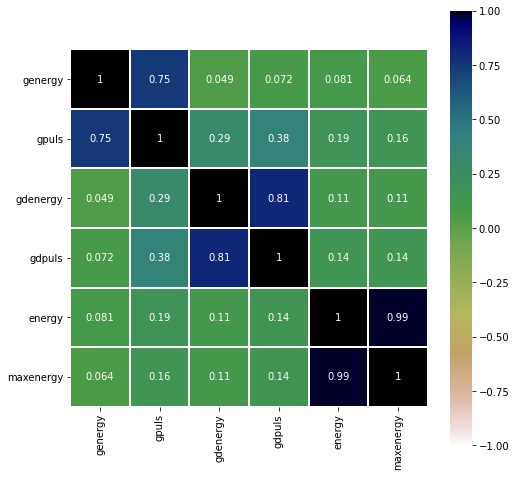

In [132]:
plt.figure(figsize=[8, 8])
sns.heatmap(data=df_corr, vmin=-1, vmax=1, cmap='gist_earth_r', annot=True, square=True, linewidths=1)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

#### genergy and gpuls

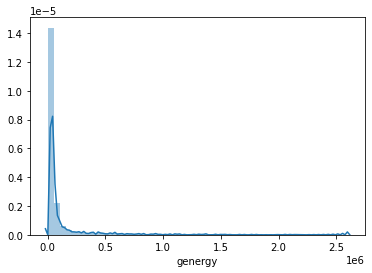

In [133]:
sns.distplot(df['genergy'], hist=True)

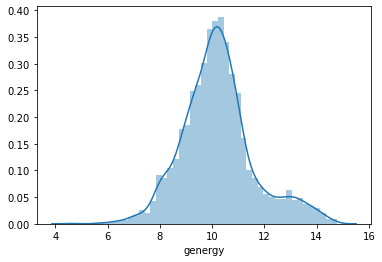

In [134]:
sns.distplot(np.log(df['genergy']), hist=True)

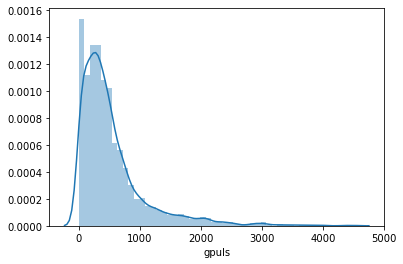

In [135]:
sns.distplot(df['gpuls'], hist=True)

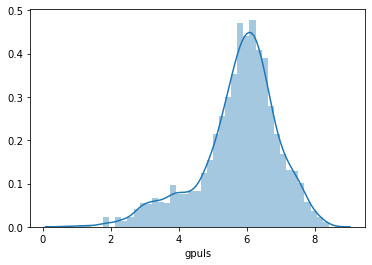

In [136]:
sns.distplot(np.log(df['gpuls']), hist=True)

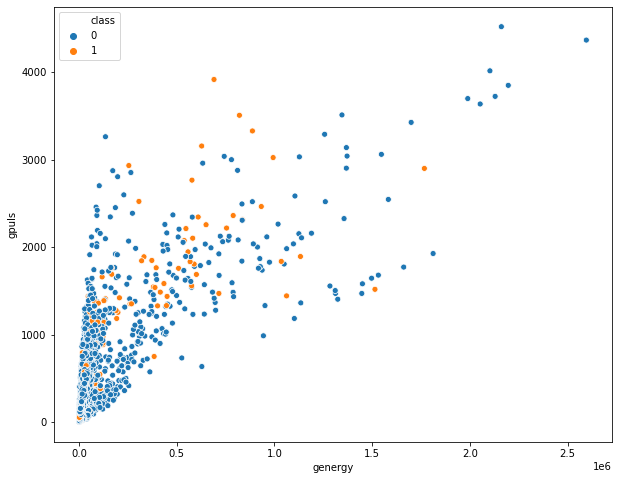

In [137]:
plt.figure(figsize=[10, 8])
sns.scatterplot(x='genergy', y='gpuls', hue='class', data=df)

In [138]:
# Applying log transform

df['log_t_genergy'] = np.log(df['genergy'])
df['log_t_gpuls'] = np.log(df['gpuls'])

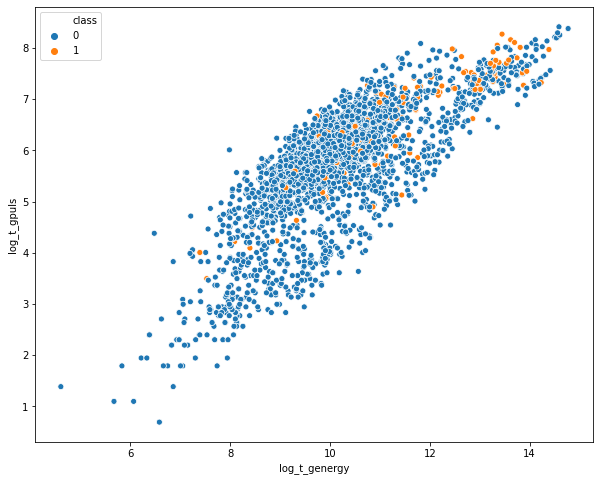

In [139]:
plt.figure(figsize=[10, 8])
sns.scatterplot(x='log_t_genergy', y='log_t_gpuls', hue='class', data=df)

In [140]:
df.drop(columns=['log_t_genergy', 'log_t_gpuls'], inplace=True)

#### gdenergy and gdpuls

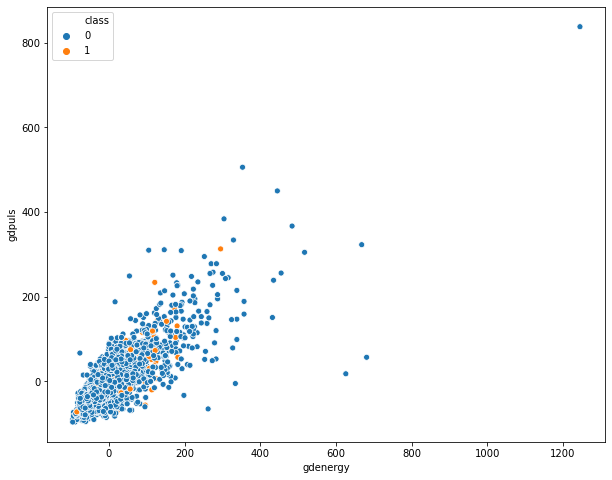

In [141]:
plt.figure(figsize=[10, 8])
sns.scatterplot(x='gdenergy', y='gdpuls', hue='class', data=df)

There are negative shifts in gdenergy and gdpuls because of which log transformation is not going to be the best choice. So, trying out square root transformation.

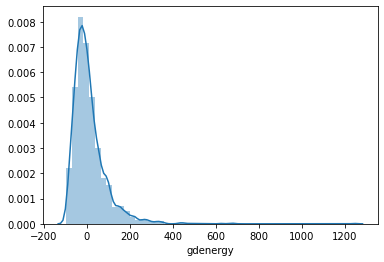

In [142]:
sns.distplot(df['gdenergy'], hist=True)

There are some negative shifts here.

C:\Users\nroy0\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


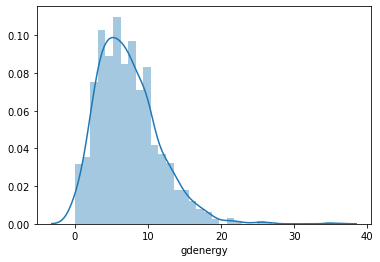

C:\Users\nroy0\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


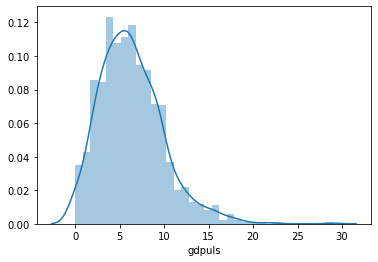

In [143]:
sns.distplot(np.sqrt(df['gdenergy']), hist=True)
plt.show()
sns.distplot(np.sqrt(df['gdpuls']), hist=True)

.. and trying out standard transformation

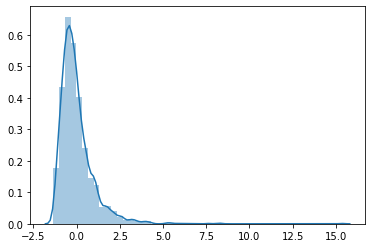

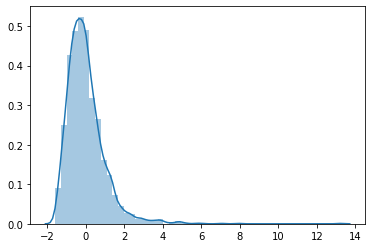

In [144]:
sns.distplot(stats.zscore(df['gdenergy']), hist=True)
plt.show()
sns.distplot(stats.zscore(df['gdpuls']), hist=True)

#### energy and maxenergy

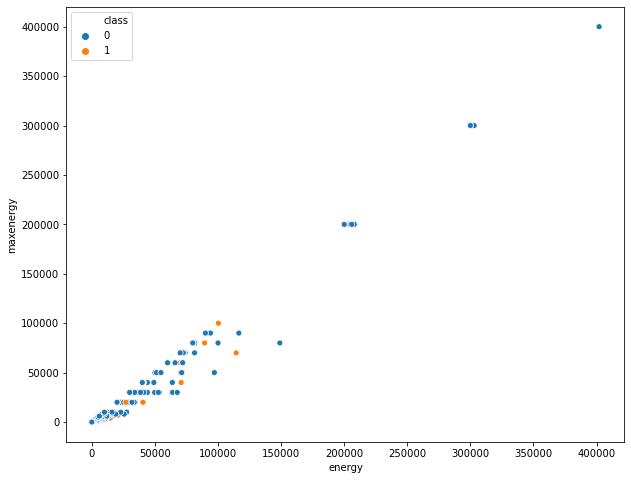

In [145]:
plt.figure(figsize=[10, 8])
sns.scatterplot(x='energy', y='maxenergy', hue='class', data=df)

A strong linear relationship is here betwen the two features.

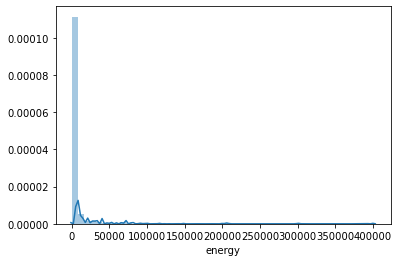

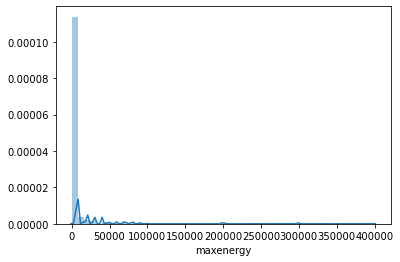

In [146]:
sns.distplot(df['energy'], hist=True)
plt.show()
sns.distplot(df['maxenergy'], hist=True)
plt.show()

There is a lot of zeroes in this feature. Therefore, using zscore again to check the distribution.

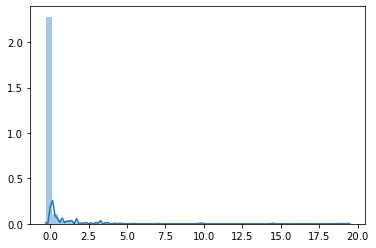

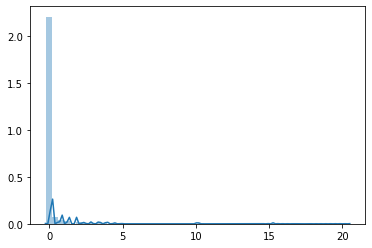

In [147]:
sns.distplot(stats.zscore(df['energy']), hist=True)
plt.show()
sns.distplot(stats.zscore(df['maxenergy']), hist=True)
plt.show()

In [148]:
stats.zscore(df['energy']).mean(), stats.zscore(df['maxenergy']).mean()

(2.1998227113315797e-17, -1.0999113556657898e-17)

Trying log transformation after adding a constant 1

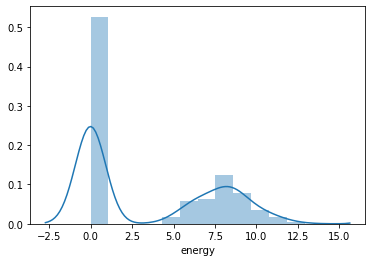

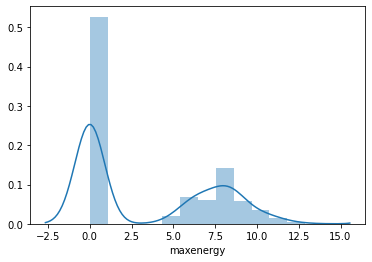

In [149]:
sns.distplot(np.log(df['energy']+1), hist=True)
plt.show()
sns.distplot(np.log(df['maxenergy']+1), hist=True)
plt.show()

For energy and maxenergy, there is little differences in the distributions as in the plots and there is almost 100% correlation in the data - so I would drop maxenergy and keep energy only. I would translate using a constant 1 and then use log transformation on energy.

**Summarizing the chosen transformation in a dictionary**

In [150]:
def shifted_log_func(df_col):
    return np.log(1 + df_col) 

In [151]:
dict_num_cols_trnsfm = {'genergy': np.log,
                        'gpuls' : np.log,
                        'gdenergy': stats.zscore,
                        'gdenergy': stats.zscore, 
                        'energy': shifted_log_func}

In [152]:
for col_names, transfm_func in dict_num_cols_trnsfm.items():
    df['scaled_' + col_names] = transfm_func(df[col_names])
df.drop(columns=col_list_numerical, inplace=True)
df.head()

,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,class,seismic_enc_0,seismoacoustic_enc_0,seismoacoustic_enc_1,shift_enc_0,ghazard_enc_0,ghazard_enc_1,scaled_genergy,scaled_gpuls,scaled_gdenergy,scaled_energy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,9.627734,3.871201,-1.050711,0.000000
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,9.596962,3.496508,-1.025805,7.601402
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.993427,3.401197,-1.162786,0.000000
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,10.268825,5.141664,-0.440526,8.006701
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,9.444622,4.043051,-0.938636,0.000000


In [153]:
df[[col for col in df.columns if 'scaled_' in col]].describe()

,scaled_genergy,scaled_gpuls,scaled_gdenergy,scaled_energy
count,2584.000000,2584.000000,2.584000e+03,2584.000000
mean,10.221063,5.761759,-1.895199e-16,3.481643
std,1.393919,1.173926,1.000194e+00,4.117081
min,4.605170,0.693147,-1.349577e+00,0.000000
25%,9.363919,5.247024,-6.148645e-01,0.000000
50%,10.145845,5.937536,-2.288290e-01,0.000000
75%,10.874880,6.505784,3.190922e-01,7.863651
max,14.769348,8.415825,1.534957e+01,12.904210


### Discrete Features

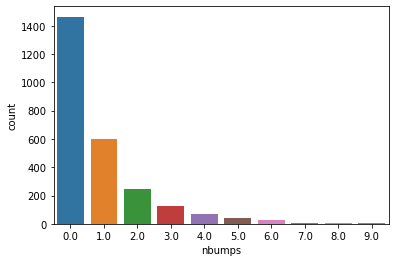

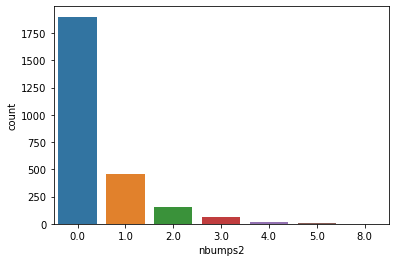

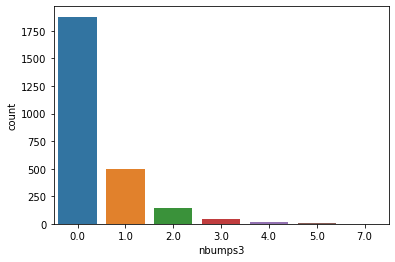

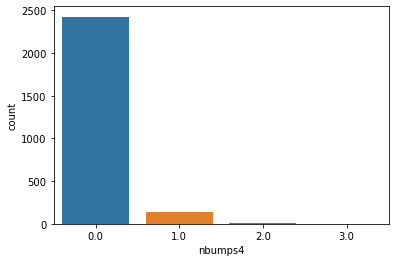

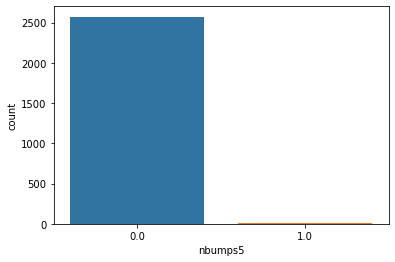

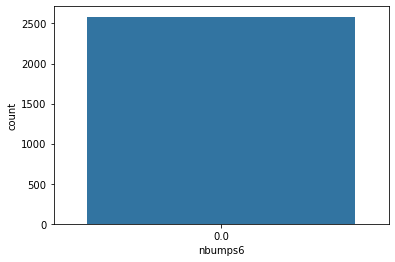

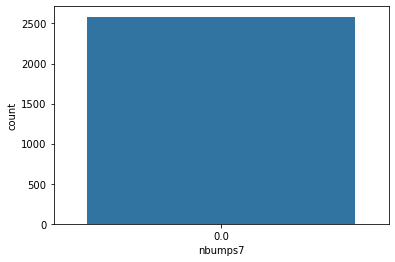

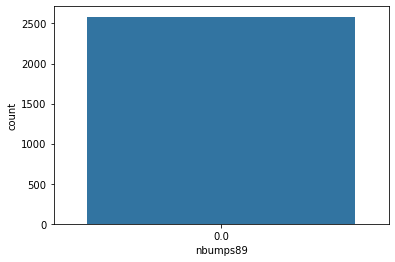

In [154]:
for col in col_list_discrete:
    sns.countplot(df[col])
    plt.show()

Since nbumps 6 , 7 & 89 contain zero, I will drop them as they have no information.

In [155]:
df.drop(columns=['nbumps6', 'nbumps7', 'nbumps89'], inplace=True)

In [156]:
df.head()

,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,class,seismic_enc_0,seismoacoustic_enc_0,seismoacoustic_enc_1,shift_enc_0,ghazard_enc_0,ghazard_enc_1,scaled_genergy,scaled_gpuls,scaled_gdenergy,scaled_energy
0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,9.627734,3.871201,-1.050711,0.000000
1,1.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,9.596962,3.496508,-1.025805,7.601402
2,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.993427,3.401197,-1.162786,0.000000
3,1.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,10.268825,5.141664,-0.440526,8.006701
4,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,9.444622,4.043051,-0.938636,0.000000


In [157]:
col_list_discrete = list(set(col_list_discrete) - set(['nbumps6', 'nbumps7', 'nbumps89']))
col_list_discrete

['nbumps5', 'nbumps', 'nbumps2', 'nbumps3', 'nbumps4']

In [158]:
for each_col in col_list_discrete:
    data_crosstab = pd.crosstab(df[each_col], df[label], colnames=['class'])
    print(data_crosstab)
    print('-----')

class       0    1
nbumps5           
0.0      2403  169
1.0        11    1
-----
class      0   1
nbumps          
0.0     1424  40
1.0      567  31
2.0      208  37
3.0       96  31
4.0       59  10
5.0       30   8
6.0       19   9
7.0        3   2
8.0        6   1
9.0        2   1
-----
class       0   1
nbumps2          
0.0      1832  69
1.0       399  56
2.0       122  29
3.0        47  11
4.0         8   4
5.0         5   1
8.0         1   0
-----
class       0   1
nbumps3          
0.0      1806  73
1.0       442  55
2.0       115  25
3.0        35   7
4.0        12   8
5.0         3   2
7.0         1   0
-----
class       0    1
nbumps4           
0.0      2278  148
1.0       123   20
2.0        12    1
3.0         1    1
-----


## Splitting Traning and Test data using Stratified Shuffle Split

In [159]:
df.shape

(2584, 16)

In [160]:
list(set(df.columns) - set([label]))

['nbumps',
 'scaled_gdenergy',
 'ghazard_enc_0',
 'seismic_enc_0',
 'nbumps2',
 'ghazard_enc_1',
 'nbumps3',
 'scaled_genergy',
 'nbumps4',
 'scaled_gpuls',
 'seismoacoustic_enc_0',
 'shift_enc_0',
 'scaled_energy',
 'nbumps5',
 'seismoacoustic_enc_1']

In [161]:
# OLD CODE FOR DEMO
X_demo = df[list(set(df.columns) - set([label]))]
y_demo1 = df[label]
y_demo2 = df[[label]]
X_demo.shape, y_demo1.shape, y_demo2.shape

((2584, 15), (2584,), (2584, 1))

In [162]:
type(X_demo), type(y_demo1), type(y_demo2)

(pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.frame.DataFrame)

In [163]:
X = df[list(set(df.columns) - set([label]))].values
y = df[label]
X.shape, y.shape

((2584, 15), (2584,))

In [164]:
type(X), type(y)

(numpy.ndarray, pandas.core.series.Series)

In [165]:
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.20)

In [166]:
for train_idx, test_idx in stratified_split.split(X, y):
    print(len(train_idx))
    print(len(test_idx))
    y_train= y[train_idx]
    X_train = X[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

len(X_train), len(y_train), len(X_test), len(y_test)

2067
517


(2067, 2067, 517, 517)

In [167]:
print("Training Set Target Class Distribution:")
print(y_train.value_counts()/len(y_train))
print("Test Set Target Class Distribution:")
print(y_test.value_counts()/len(y_test))

Training Set Target Class Distribution:
0    0.934204
1    0.065796
Name: class, dtype: float64
Test Set Target Class Distribution:
0    0.934236
1    0.065764
Name: class, dtype: float64


In [168]:
X_train_demo, X_test_demo, y_train_demo, y_test_demo = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)
X_train_demo.shape, X_test_demo.shape, y_train_demo.shape, y_test_demo.shape, y_train_demo.value_counts()/len(y_train_demo), y_test_demo.value_counts()/len(y_test_demo)

((1731, 15),
 (853, 15),
 (1731,),
 (853,),
 0    0.9197
 1    0.0803
 Name: class, dtype: float64,
 0    0.963658
 1    0.036342
 Name: class, dtype: float64)

In [169]:
print("Training Set Target Class Distribution:")
print(y_train_demo.value_counts()/len(y_train_demo))
print("Test Set Target Class Distribution:")
print(y_test_demo.value_counts()/len(y_test_demo))

Training Set Target Class Distribution:
0    0.9197
1    0.0803
Name: class, dtype: float64
Test Set Target Class Distribution:
0    0.963658
1    0.036342
Name: class, dtype: float64


In [170]:
X_train_demo, X_test_demo, y_train_demo, y_test_demo = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)
X_train_demo.shape, X_test_demo.shape, y_train_demo.shape, y_test_demo.shape, y_train_demo.value_counts()/len(y_train_demo), y_test_demo.value_counts()/len(y_test_demo)

((1731, 15),
 (853, 15),
 (1731,),
 (853,),
 0    0.935875
 1    0.064125
 Name: class, dtype: float64,
 0    0.930832
 1    0.069168
 Name: class, dtype: float64)

In [171]:
print("Training Set Target Class Distribution:")
print(y_train_demo.value_counts()/len(y_train_demo))
print("Test Set Target Class Distribution:")
print(y_test_demo.value_counts()/len(y_test_demo))

Training Set Target Class Distribution:
0    0.935875
1    0.064125
Name: class, dtype: float64
Test Set Target Class Distribution:
0    0.930832
1    0.069168
Name: class, dtype: float64


## Save models to a particular folder

In [172]:
import datetime

def model_store_location():
    return "model-store-{}".format(datetime.date.today())

model_store_location = model_store_location()
print(model_store_location)
!mkdir {model_store_location}
model_store_location += '/'
model_store_location

model-store-2020-09-02


'model-store-2020-09-02/'

## Applying ML model to Predict Hazardrous Seismic Bump

### K-Neighbors Classifier using Stratified KFold Cross Validation

#### Establishing Baseline

In [78]:
model = KNeighborsClassifier()
skf = StratifiedKFold(n_splits=10)

In [79]:
'''
Demo of split using original features and label columns
split is 90-10
'''

for train, test in skf.split(X, y):
    print(len(train))
    print(y[train].value_counts()/len(train))
    print('----')
    print(len(test))
    print(y[test].value_counts()/len(test))
    print('----')
    break

2325
0    0.934194
1    0.065806
Name: class, dtype: float64
----
259
0    0.934363
1    0.065637
Name: class, dtype: float64
----


#### Using cross_val_score for performance metrics

In [80]:
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1, error_score='raise')
scores

array([0.9178744 , 0.9178744 , 0.9178744 , 0.90821256, 0.90821256,
       0.93236715, 0.92270531, 0.9368932 , 0.92718447, 0.94174757])

In [81]:
scores.mean(), scores.std()

(0.9230946015665307, 0.010797663552537693)

In [82]:
scores = cross_val_score(model, X_train, y_train, scoring='f1', cv=skf, n_jobs=-1, error_score='raise')
scores.mean(), scores.std()

(0.06707393483709273, 0.0789663185376067)

I was getting an error "pos_label=1 is not a valid label: array(['0', '1'], dtype='<U1')" which I resolved by typecasting the labels into integers. This blocked me for 1 whole day sicne I had run the code before which successfully ran. This is when i noticed one-hot encoders transformed all the features I fed into it were transformed to float including my label column. So when I ran the code, it worked. But when I  excluded it, the object type of the label column caused this trouble.

In [83]:
model.n_neighbors, model.weights

(5, 'uniform')

In [84]:
model.fit(X_train, y_train)

KNeighborsClassifier()

In [85]:
y_pred = model.predict(X_test)

#### Add model results to a DataFrame

In [86]:
df_results = pd.DataFrame(index = ['scoring_technique', 'algorithm', 'n_neighbors', 'weights', 'leaf_size', 'accuracy', 'precision', 'recall', 'f1-score'])

In [87]:
df_results['Baseline'] = ['None', model.algorithm,
                          model.n_neighbors, 
                          model.weights, 
                          model.leaf_size,
                          accuracy_score(y_test, y_pred), 
                          precision_score(y_test, y_pred), 
                          recall_score(y_test, y_pred), 
                          f1_score(y_test, y_pred)]

In [88]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

#### Using cross_validate for performance metrics

In [89]:
scores = cross_validate(model, X_train, y_train, scoring=['precision', 'recall', 'f1'], cv=skf, n_jobs=-1, error_score='raise')
scores.keys()

dict_keys(['fit_time', 'score_time', 'test_precision', 'test_recall', 'test_f1'])

In [90]:
scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_f1'].mean()

(0.1619047619047619, 0.0445054945054945, 0.06707393483709273)

In [91]:
scoring = {'precision': 'precision', 
           'recall': 'recall',
           'roc_auc': 'roc_auc'}

In [92]:
scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=10, return_train_score=True)
sorted(scores.keys())

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['fit_time',
 'score_time',
 'test_precision',
 'test_recall',
 'test_roc_auc',
 'train_precision',
 'train_recall',
 'train_roc_auc']

In [93]:
scores['test_precision'].mean(), scores['test_recall'].mean(), scores['test_roc_auc'].mean()

(0.1619047619047619, 0.0445054945054945, 0.6672897011113452)

#### Tuning model using Grid Search CV using 'Precision'

In [94]:
n_neighbors = [1, 2, 3, 4, 5]
weights = ['uniform', 'distance']
algorithm = ['ball_tree', 'kd_tree', 'brute']
leaf_size = [10, 20, 30 , 40, 50]

param_grid = dict(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, leaf_size=leaf_size)

In [95]:
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    cv=StratifiedKFold(shuffle=True), 
                    scoring=['precision'],
                    refit='precision',
                    verbose=10)

In [170]:
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, precision=0.077, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, precision=0.083, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, precision=0.280, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, precision=0.316, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, we

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s


[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, precision=1.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, precision=0.250, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=distance, precision=0.077, total=   0.0s
[CV] algorithm

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=3, weights=uniform, precision=0.500, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=3, weights=uniform, precision=0.200, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=3, weights=uniform, precision=0.143, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=3, weights=uniform, precision=0.100, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=3, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=3, weights=distance, precision=0.143, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=3, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=3, weights=distance, precision=0.400, total=   0.0s
[CV] algorit

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, weights=uniform, precision=0.200, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, weights=distance, precision=0.500, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, weights=distance, precision=0.125, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, weights=distance, precision=0.222, total=   0.0s
[CV] alg

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=3, weights=uniform, precision=0.154, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=3, weights=uniform, precision=0.500, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=3, weights=uniform, precision=0.200, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=3, weights=uniform, precision=0.143, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=3, weights=uniform, precision=0.100, total=   0.0s
[CV] algorithm=

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=uniform, precision=0.143, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=distance, precision=0.143, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=distance, precision=0.667, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=distance, precision=0.000, total=   0.0s
[CV] algor

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=distance, precision=0.077, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=distance, precision=0.083, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=distance, precision=0.280, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=distance, precision=0.316, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=3, weights=uniform, precision=0.154, total=   0.0s
[CV] al

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=4, weights=distance, precision=0.222, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=4, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=4, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=5, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=5, weights=uniform, precision=0.200, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=5, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=5, weights=uniform, precision=0.667, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=5, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=5, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=5, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=5, weights=uniform, precision=0.143, total=   0.0s
[CV] algorith

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=uniform, precision=0.250, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=distance, precision=0.077, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=distance, precision=0.083, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=distance, precision=0.280, total=   0.0s
[CV] algor

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=4, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=4, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=4, weights=distance, precision=0.500, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=4, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=4, weights=distance, precision=0.125, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=4, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=4, weights=distance, precision=0.222, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=4, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=4, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=5, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=5, weights=uniform, precision=0.200, total=   0.0s
[CV] al

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=2, weights=distance, precision=0.280, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=2, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=2, weights=distance, precision=0.316, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=2, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=2, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=uniform, precision=0.154, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=uniform, precision=0.500, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=uniform, precision=0.200, total=   0.0s
[CV] algori

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=4, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=5, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=5, weights=uniform, precision=0.200, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=5, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=5, weights=uniform, precision=0.667, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=5, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=5, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=5, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=5, weights=uniform, precision=0.143, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=5, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=5, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=2, weights=uniform, precision=0.250, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=2, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=2, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=2, weights=distance, precision=0.077, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=2, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=2, weights=distance, precision=0.083, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=2, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=2, weights=distance, precision=0.280, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=2, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=2, weights=distance, precision=0.316, total=   0.0s
[CV] algorithm=kd_tree, leaf_

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=distance, precision=0.500, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=distance, precision=0.125, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=distance, precision=0.222, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=5, weights=uniform, precision=0.200, total=   0.0s
[CV] algorithm=kd_tree, leaf

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=2, weights=distance, precision=0.280, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=2, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=2, weights=distance, precision=0.316, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=2, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=2, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=3, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=3, weights=uniform, precision=0.154, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=3, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=3, weights=uniform, precision=0.500, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=3, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=3, weights=uniform, precision=0.200, total=   0.0s
[CV] algorithm=kd_tree, leaf_s

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=distance, precision=0.222, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=5, weights=uniform, precision=0.200, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=5, weights=uniform, precision=0.667, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=5, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=5, weights=uniform, precision=0.143, total=   0.0s
[CV] algorithm=kd_tree, leaf_si

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=2, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=2, weights=uniform, precision=0.250, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=2, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=2, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=2, weights=distance, precision=0.077, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=2, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=2, weights=distance, precision=0.083, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=2, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=2, weights=distance, precision=0.280, total=   0.0s
[CV] algorithm=kd_tree, leaf_s

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=distance, precision=0.500, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=distance, precision=0.125, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=distance, precision=0.222, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=uniform, precision=0.200, total=   0.0s
[CV] algorithm=kd_tree, leaf

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=3, weights=uniform, precision=0.200, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=3, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=3, weights=uniform, precision=0.143, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=3, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=3, weights=uniform, precision=0.100, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=3, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=3, weights=distance, precision=0.143, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=3, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=3, weights=distance, precision=0.400, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=3, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=3, weights=distance, precision=0.143, total=   0.0s
[CV] algorithm=kd_tree, leaf_s

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=4, weights=uniform, precision=0.200, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=4, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=4, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=4, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=4, weights=distance, precision=0.500, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=4, weights=distance, precision=0.125, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=4, weights=distance, precision=0.222, total=   0.0s
[CV] algorithm=kd_tree, leaf_

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=3, weights=uniform, precision=0.154, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=3, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=3, weights=uniform, precision=0.500, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=3, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=3, weights=uniform, precision=0.200, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=3, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=3, weights=uniform, precision=0.143, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=3, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=3, weights=uniform, precision=0.100, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=3, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=3, weights=distance, precision=0.143, total=   0.0s
[CV] algorithm=kd_tree, leaf_siz

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=uniform, precision=0.143, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=distance, precision=0.143, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=distance, precision=0.667, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=distance, precision=0.250, total=   0.0s
[CV] algorithm=kd_tree, leaf_

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[CV] algorithm=brute, leaf_size=10, n_neighbors=2, weights=distance ..
[CV]  algorithm=brute, leaf_size=10, n_neighbors=2, weights=distance, precision=0.083, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=2, weights=distance ..
[CV]  algorithm=brute, leaf_size=10, n_neighbors=2, weights=distance, precision=0.280, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=2, weights=distance ..
[CV]  algorithm=brute, leaf_size=10, n_neighbors=2, weights=distance, precision=0.316, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=2, weights=distance ..
[CV]  algorithm=brute, leaf_size=10, n_neighbors=2, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=3, weights=uniform ...
[CV]  algorithm=brute, leaf_size=10, n_neighbors=3, weights=uniform, precision=0.154, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=3, weights=uniform ...
[CV]  algorithm=brute, leaf_size=10, n_neighbors=3, weights=uniform, 

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, weights=distance, precision=0.500, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, weights=distance, precision=0.125, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, weights=distance, precision=0.222, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=10, n_neighbors=5, weights=uniform, precision=0.200, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_ne

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[CV] algorithm=brute, leaf_size=20, n_neighbors=3, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=3, weights=uniform, precision=0.154, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=3, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=3, weights=uniform, precision=0.500, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=3, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=3, weights=uniform, precision=0.200, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=3, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=3, weights=uniform, precision=0.143, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=3, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=3, weights=uniform, precision=0.100, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=3, weights=distance ..
[CV]  algorithm=brute, leaf_size=20, n_neighbors=3, weights=distance, pre

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[CV] algorithm=brute, leaf_size=20, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=20, n_neighbors=4, weights=distance, precision=0.222, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=20, n_neighbors=4, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=5, weights=uniform, precision=0.200, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=5, weights=uniform, precision=0.667, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=5, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=5, weights=uniform, pr

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[CV] algorithm=brute, leaf_size=30, n_neighbors=2, weights=distance ..
[CV]  algorithm=brute, leaf_size=30, n_neighbors=2, weights=distance, precision=0.316, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=2, weights=distance ..
[CV]  algorithm=brute, leaf_size=30, n_neighbors=2, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=3, weights=uniform ...
[CV]  algorithm=brute, leaf_size=30, n_neighbors=3, weights=uniform, precision=0.154, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=3, weights=uniform ...
[CV]  algorithm=brute, leaf_size=30, n_neighbors=3, weights=uniform, precision=0.500, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=3, weights=uniform ...
[CV]  algorithm=brute, leaf_size=30, n_neighbors=3, weights=uniform, precision=0.200, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=3, weights=uniform ...
[CV]  algorithm=brute, leaf_size=30, n_neighbors=3, weights=uniform, pr

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] algorithm=brute, leaf_size=30, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=30, n_neighbors=4, weights=distance, precision=0.222, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=30, n_neighbors=4, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=30, n_neighbors=5, weights=uniform, precision=0.200, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=30, n_neighbors=5, weights=uniform, precision=0.667, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=30, n_neighbors=5, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=30, n_neighbors=5, weights=uniform, pre

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[CV] algorithm=brute, leaf_size=40, n_neighbors=2, weights=distance ..
[CV]  algorithm=brute, leaf_size=40, n_neighbors=2, weights=distance, precision=0.316, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=2, weights=distance ..
[CV]  algorithm=brute, leaf_size=40, n_neighbors=2, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=3, weights=uniform ...
[CV]  algorithm=brute, leaf_size=40, n_neighbors=3, weights=uniform, precision=0.154, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=3, weights=uniform ...
[CV]  algorithm=brute, leaf_size=40, n_neighbors=3, weights=uniform, precision=0.500, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=3, weights=uniform ...
[CV]  algorithm=brute, leaf_size=40, n_neighbors=3, weights=uniform, precision=0.200, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=3, weights=uniform ...
[CV]  algorithm=brute, leaf_size=40, n_neighbors=3, weights=uniform, pr

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=brute, leaf_size=40, n_neighbors=4, weights=distance, precision=0.500, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=40, n_neighbors=4, weights=distance, precision=0.125, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=40, n_neighbors=4, weights=distance, precision=0.222, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=40, n_neighbors=4, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=40, n_neighbors=5, weights=uniform, precision=0.200, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=40, n_neighbors=5, weights=uniform, precision=0.667, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_nei

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=brute, leaf_size=50, n_neighbors=2, weights=distance, precision=0.316, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=2, weights=distance ..
[CV]  algorithm=brute, leaf_size=50, n_neighbors=2, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=3, weights=uniform ...
[CV]  algorithm=brute, leaf_size=50, n_neighbors=3, weights=uniform, precision=0.154, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=3, weights=uniform ...
[CV]  algorithm=brute, leaf_size=50, n_neighbors=3, weights=uniform, precision=0.500, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=3, weights=uniform ...
[CV]  algorithm=brute, leaf_size=50, n_neighbors=3, weights=uniform, precision=0.200, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=3, weights=uniform ...
[CV]  algorithm=brute, leaf_size=50, n_neighbors=3, weights=uniform, precision=0.143, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neigh

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=brute, leaf_size=50, n_neighbors=4, weights=distance, precision=0.125, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=50, n_neighbors=4, weights=distance, precision=0.222, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=50, n_neighbors=4, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=50, n_neighbors=5, weights=uniform, precision=0.200, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=50, n_neighbors=5, weights=uniform, precision=0.667, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=50, n_neighbors=5, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neig

[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:   13.7s finished


In [171]:
grid_result.cv_results_

{'mean_fit_time': array([0.00478387, 0.00496526, 0.00519199, 0.00478592, 0.00442948,
        0.00458188, 0.00498214, 0.00478792, 0.00459738, 0.00497451,
        0.00438237, 0.00420446, 0.00439706, 0.00419035, 0.0045836 ,
        0.00458746, 0.00458708, 0.00421386, 0.00499091, 0.00439816,
        0.00400705, 0.00419078, 0.00419059, 0.00381308, 0.00399399,
        0.00420289, 0.00400901, 0.00418029, 0.00381532, 0.00422525,
        0.00438981, 0.00379825, 0.00421643, 0.00361981, 0.00419369,
        0.00396581, 0.00361261, 0.00401096, 0.0043891 , 0.0041995 ,
        0.00439281, 0.00382109, 0.00420809, 0.00420122, 0.00419798,
        0.00442061, 0.00379572, 0.00360565, 0.00393786, 0.00380659,
        0.00758014, 0.00699325, 0.00722136, 0.00678387, 0.00697508,
        0.00779595, 0.00759091, 0.00818915, 0.00756426, 0.00796161,
        0.00638285, 0.00659299, 0.00698457, 0.00619898, 0.00697622,
        0.00698109, 0.00699382, 0.00661016, 0.00678339, 0.00679717,
        0.00578032, 0.00578809,

In [172]:
grid_result.best_estimator_

KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=2)

In [173]:
grid_result.best_score_

0.25

In [174]:
n_neighbors, weights = grid_result.best_estimator_.n_neighbors , grid_result.best_estimator_.weights

In [175]:
n_neighbors, weights

(2, 'uniform')

In [176]:
grid_result.scorer_

{'precision': make_scorer(precision_score, average=binary)}

In [177]:
grid_result.n_splits_

5

In [178]:
model = grid_result.best_estimator_

In [179]:
model

KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, n_neighbors=2)

In [180]:
file_name = 'seismic_bump_k_neighbors_'+ str(n_neighbors) + '_' + weights + '_' + list(grid_result.scorer_.keys())[0]+'.sav'
joblib.dump(model, model_store_location + file_name)

['model-store-2020-08-05/seismic_bump_k_neighbors_2_uniform_precision.sav']

In [181]:
y_pred = model.predict(X_test)

In [182]:
y_pred.shape

(517,)

In [183]:
confusion_matrix(y_test, y_pred)

array([[479,   4],
       [ 34,   0]], dtype=int64)

In [184]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(479, 4, 34, 0)

In [185]:
accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred), f1_score(y_test, y_pred)

(0.9264990328820116, 0.0, 0.0, 0.0)

In [186]:
df_results['Model 1'] = [grid.get_params(deep=True)['scoring'], grid_result.best_estimator_.algorithm,
                         n_neighbors, weights, grid_result.best_estimator_.leaf_size,
                         accuracy_score(y_test, y_pred), 
                         precision_score(y_test, y_pred), recall_score(y_test, y_pred), 
                         f1_score(y_test, y_pred)]

In [187]:
df_results

,Baseline,Model 1
scoring_technique,None,[precision]
algorithm,auto,ball_tree
n_neighbors,5,2
weights,uniform,uniform
leaf_size,30,10
accuracy,0.926499,0.926499
precision,0.25,0
recall,0.0588235,0
f1-score,0.0952381,0


#### Tuning model using Grid Search CV using 'Precision'  again

In [188]:
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    cv=StratifiedKFold(shuffle=True), 
                    scoring=['precision'],
                    refit='precision',
                    verbose=10)
grid_result = grid.fit(X_train, y_train)
n_neighbors, weights = grid_result.best_estimator_.n_neighbors , grid_result.best_estimator_.weights
file_name = 'seismic_bump_k_neighbors_'+ str(n_neighbors) + '_' + weights + '_' + list(grid_result.scorer_.keys())[0]+'.sav'
joblib.dump(model, model_store_location + file_name)
print(grid_result.best_score_)
print(grid_result.best_estimator_)
y_pred = grid_result.best_estimator_.predict(X_test)

accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred), f1_score(y_test, y_pred)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, precision=0.143, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, precision=0.074, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, precision=0.161, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, precision=0.269, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, we

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s


[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=distance, precision=0.269, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, precision=0.250, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, weights=uniform, precision=0.600, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, weights=uniform, precision=0.500, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, weights=distance, precision=0.571, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=4, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=4, weights=distance, precision=0.100, total=   0.0s
[CV] algorit

[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=3, weights=distance, precision=0.143, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=4, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=4, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=4, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=4, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=4, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=4, weights=uniform, precision=0.600, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=4, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=4, weights=uniform, precision=0.500, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=4, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=4, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=uniform, precision=0.333, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=uniform, precision=0.250, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=uniform, precision=0.375, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=uniform, precision=0.500, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=distance, precision=0.429, total=   0.0s
[CV] algorithm

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=4, weights=distance, precision=0.429, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=4, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=4, weights=distance, precision=0.286, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=4, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=4, weights=distance, precision=0.286, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=5, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=5, weights=uniform, precision=0.333, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=5, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=5, weights=uniform, precision=0.250, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=5, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=5, weights=uniform, precision=0.375, total=   0.0s
[CV] algori

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=4, weights=distance, precision=0.571, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=4, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=4, weights=distance, precision=0.100, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=4, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=4, weights=distance, precision=0.429, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=4, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=4, weights=distance, precision=0.286, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=4, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=4, weights=distance, precision=0.286, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=5, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=5, weights=uniform, precision=0.333, total=   0.0s
[CV] al

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=4, weights=uniform, precision=0.600, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=4, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=4, weights=uniform, precision=0.500, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=4, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=4, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=4, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=4, weights=distance, precision=0.571, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=4, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=4, weights=distance, precision=0.100, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=4, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=4, weights=distance, precision=0.429, total=   0.0s
[CV] algor

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=distance, precision=0.571, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=distance, precision=0.100, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=distance, precision=0.429, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=distance, precision=0.286, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=distance, precision=0.286, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=5, weights=uniform, precision=0.333, total=   0.0s
[CV] algorithm=kd_tree, leaf

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform, precision=0.600, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform, precision=0.500, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=distance, precision=0.571, total=   0.0s
[CV] algorithm=kd_tree, leaf_siz

[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=3, weights=distance, precision=0.222, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=3, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=3, weights=distance, precision=0.143, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=uniform, precision=0.600, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=uniform, precision=0.500, total=   0.0s
[CV] algorithm=kd_tree, leaf_si

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=uniform, precision=0.333, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=uniform, precision=0.250, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=uniform, precision=0.375, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=uniform, precision=0.500, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=distance, precision=0.429, total=   0.0s
[CV] algorithm=kd_tree, leaf_siz

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=uniform, precision=0.250, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=uniform, precision=0.375, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=uniform, precision=0.500, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=distance, precision=0.429, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=distance, precision=0.143, total=   0.0s
[CV] algorithm=kd_tree, leaf_si

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=4, weights=distance, precision=0.286, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=uniform, precision=0.333, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=uniform, precision=0.250, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=uniform, precision=0.375, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=uniform, precision=0.500, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_siz

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, weights=distance, precision=0.571, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, weights=distance, precision=0.100, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, weights=distance, precision=0.429, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, weights=distance, precision=0.286, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, weights=distance, precision=0.286, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=10, n_neighbors=5, weights=uniform, precision=0.333, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_ne

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=brute, leaf_size=20, n_neighbors=4, weights=distance, precision=0.286, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=5, weights=uniform, precision=0.333, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=5, weights=uniform, precision=0.250, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=5, weights=uniform, precision=0.375, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=5, weights=uniform, precision=0.500, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=5, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighb

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=brute, leaf_size=30, n_neighbors=4, weights=uniform, precision=0.600, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=4, weights=uniform ...
[CV]  algorithm=brute, leaf_size=30, n_neighbors=4, weights=uniform, precision=0.500, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=4, weights=uniform ...
[CV]  algorithm=brute, leaf_size=30, n_neighbors=4, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=30, n_neighbors=4, weights=distance, precision=0.571, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=30, n_neighbors=4, weights=distance, precision=0.100, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=30, n_neighbors=4, weights=distance, precision=0.429, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neig

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=brute, leaf_size=40, n_neighbors=4, weights=distance, precision=0.100, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=40, n_neighbors=4, weights=distance, precision=0.429, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=40, n_neighbors=4, weights=distance, precision=0.286, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=40, n_neighbors=4, weights=distance, precision=0.286, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=40, n_neighbors=5, weights=uniform, precision=0.333, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=40, n_neighbors=5, weights=uniform, precision=0.250, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_nei

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  algorithm=brute, leaf_size=50, n_neighbors=4, weights=distance, precision=0.429, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=50, n_neighbors=4, weights=distance, precision=0.286, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=50, n_neighbors=4, weights=distance, precision=0.286, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=50, n_neighbors=5, weights=uniform, precision=0.333, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=50, n_neighbors=5, weights=uniform, precision=0.250, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=50, n_neighbors=5, weights=uniform, precision=0.375, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neig

[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:   13.5s finished


(0.9187620889748549,
 0.058823529411764705,
 0.16666666666666666,
 0.08695652173913045)

In [189]:
df_results['Model 2'] = [grid.get_params(deep=True)['scoring'], grid_result.best_estimator_.algorithm,
                         n_neighbors, weights, grid_result.best_estimator_.leaf_size,
                         accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), 
                         recall_score(y_test, y_pred), f1_score(y_test, y_pred)]

#### Tuning model using Grid Search CV using 'Recall' 

In [190]:
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    cv=StratifiedKFold(shuffle=True), 
                    scoring=['recall'],
                    refit='recall',
                    verbose=10)
grid_result = grid.fit(X_train, y_train)
n_neighbors, weights = grid_result.best_estimator_.n_neighbors , grid_result.best_estimator_.weights
file_name = 'seismic_bump_k_neighbors_'+ str(n_neighbors) + '_' + weights + '_' + list(grid_result.scorer_.keys())[0]+'.sav'
joblib.dump(model, model_store_location + file_name)
print(grid_result.best_score_)
print(grid_result.best_estimator_)
y_pred = grid_result.best_estimator_.predict(X_test)

accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred), f1_score(y_test, y_pred)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, recall=0.074, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s


[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, recall=0.107, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, recall=0.148, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, recall=0.111, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, recall=0.222, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=distance, recall=0.074, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=distance, recall=0.107, total=   0.0s
[CV] algorithm=ball_tree, leaf

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s


[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=distance, recall=0.222, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, recall=0.037, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_si

[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=1, weights=distance, recall=0.111, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=1, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=1, weights=distance, recall=0.222, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=uniform, recall=0.037, total=   0.0s
[CV] algorithm=ball_tree, leaf_

[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=1, weights=distance, recall=0.107, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=1, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=1, weights=distance, recall=0.148, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=1, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=1, weights=distance, recall=0.111, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=1, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=1, weights=distance, recall=0.222, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=ball_tree, l

[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=1, weights=uniform, recall=0.222, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=1, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=1, weights=distance, recall=0.074, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=1, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=1, weights=distance, recall=0.107, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=1, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=1, weights=distance, recall=0.148, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=1, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=1, weights=distance, recall=0.111, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=1, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=1, weights=distance, recall=0.222, total=   0.0s
[CV] algorithm=ball_tree

[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=2, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=2, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=2, weights=uniform, recall=0.037, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=2, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=2, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=2, weights=distance, recall=0.074, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=2, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=2, weights=distance, recall=0.107, total=   0.0s
[CV] algorithm=ball_tree, leaf

[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=1, weights=distance, recall=0.222, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=2, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=2, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=2, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=2, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=2, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=2, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=2, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=2, weights=uniform, recall=0.037, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=2, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=2, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=

[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=1, weights=distance, recall=0.222, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=2, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=2, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=2, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=2, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=2, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=2, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=2, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=2, weights=uniform, recall=0.037, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=2, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=2, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=

[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=2, weights=distance, recall=0.222, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=3, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=3, weights=uniform, recall=0.111, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=3, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=3, weights=uniform, recall=0.036, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=3, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=3, weights=uniform, recall=0.037, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=3, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=3, weights=uniform, recall=0.074, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=3, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=3, weights=uniform, recall=0.037, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=

[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=3, weights=uniform, recall=0.036, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=3, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=3, weights=uniform, recall=0.037, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=3, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=3, weights=uniform, recall=0.074, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=3, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=3, weights=uniform, recall=0.037, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=3, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=3, weights=distance, recall=0.111, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=3, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=3, weights=distance, recall=0.036, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors

[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=3, weights=uniform, recall=0.037, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=3, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=3, weights=uniform, recall=0.074, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=3, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=3, weights=uniform, recall=0.037, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=3, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=3, weights=distance, recall=0.111, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=3, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=3, weights=distance, recall=0.036, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=3, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=3, weights=distance, recall=0.037, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbor

[CV]  algorithm=brute, leaf_size=10, n_neighbors=3, weights=distance, recall=0.037, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, weights=uniform ...
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, weights=uniform, recall=0.037, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, weights=uniform ...
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, weights=uniform ...
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, weights=uniform ...
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, weights=uniform, recall=0.037, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, weights=uniform ...
[CV]  algorithm=brute, leaf_size=10, n_neighbors=4, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=4, weights=dis

[CV]  algorithm=brute, leaf_size=20, n_neighbors=4, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=4, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=4, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=4, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=4, weights=uniform, recall=0.037, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=4, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=4, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=20, n_neighbors=4, weights=distance, recall=0.111, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=20, n_neighbors=4, weights=distance, recall=0.071, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=4, weights=di

[CV]  algorithm=brute, leaf_size=30, n_neighbors=4, weights=uniform, recall=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=30, n_neighbors=4, weights=distance, recall=0.111, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=30, n_neighbors=4, weights=distance, recall=0.071, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=30, n_neighbors=4, weights=distance, recall=0.037, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=30, n_neighbors=4, weights=distance, recall=0.074, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=30, n_neighbors=4, weights=distance, recall=0.074, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=5, weights

[CV]  algorithm=brute, leaf_size=40, n_neighbors=4, weights=distance, recall=0.071, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=40, n_neighbors=4, weights=distance, recall=0.037, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=40, n_neighbors=4, weights=distance, recall=0.074, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=40, n_neighbors=4, weights=distance, recall=0.074, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=40, n_neighbors=5, weights=uniform, recall=0.074, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=40, n_neighbors=5, weights=uniform, recall=0.036, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=5, weights=

[CV]  algorithm=brute, leaf_size=50, n_neighbors=4, weights=distance, recall=0.037, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=50, n_neighbors=4, weights=distance, recall=0.074, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=4, weights=distance ..
[CV]  algorithm=brute, leaf_size=50, n_neighbors=4, weights=distance, recall=0.074, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=50, n_neighbors=5, weights=uniform, recall=0.074, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=50, n_neighbors=5, weights=uniform, recall=0.036, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=5, weights=uniform ...
[CV]  algorithm=brute, leaf_size=50, n_neighbors=5, weights=uniform, recall=0.074, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=5, weights=u

[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:   13.5s finished


(0.8878143133462283,
 0.029411764705882353,
 0.038461538461538464,
 0.03333333333333333)

In [191]:
df_results['Model 3'] = [grid.get_params(deep=True)['scoring'], grid_result.best_estimator_.algorithm,
                         n_neighbors, weights, grid_result.best_estimator_.leaf_size,
                         accuracy_score(y_test, y_pred), 
                         precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)]

In [192]:
df_results

,Baseline,Model 1,Model 2,Model 3
scoring_technique,None,[precision],[precision],[recall]
algorithm,auto,ball_tree,ball_tree,ball_tree
n_neighbors,5,2,4,1
weights,uniform,uniform,distance,uniform
leaf_size,30,10,10,10
accuracy,0.926499,0.926499,0.918762,0.887814
precision,0.25,0,0.166667,0.0384615
recall,0.0588235,0,0.0588235,0.0294118
f1-score,0.0952381,0,0.0869565,0.0333333


#### Tuning model using Grid Search CV using 'f1' 

In [193]:
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    cv=StratifiedKFold(shuffle=True), 
                    scoring=['f1'],
                    refit='f1',
                    verbose=10)
grid_result = grid.fit(X_train, y_train)
n_neighbors, weights = grid_result.best_estimator_.n_neighbors , grid_result.best_estimator_.weights
file_name = 'seismic_bump_k_neighbors_'+ str(n_neighbors) + '_' + weights + '_' + list(grid_result.scorer_.keys())[0]+'.sav'
joblib.dump(model, model_store_location + file_name)
print(grid_result.best_score_)
print(grid_result.best_estimator_)
y_pred = grid_result.best_estimator_.predict(X_test)

accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred), f1_score(y_test, y_pred)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, f1=0.151, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, f1=0.037, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, f1=0.082, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, f1=0.163, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, f1=0.172, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=distance, f1=0.151

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s


[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=distance, f1=0.082, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=distance 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s


[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=distance, f1=0.163, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=distance, f1=0.172, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, f1=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, f1=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, f1=0.062, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, f1=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, 

[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=1, weights=distance, f1=0.082, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=1, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=1, weights=distance, f1=0.163, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=1, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=1, weights=distance, f1=0.172, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=uniform, f1=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=uniform, f1=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=uniform, f1=0.062, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=2

[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=uniform, f1=0.062, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=uniform, f1=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=uniform, f1=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=distance, f1=0.151, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=distance, f1=0.037, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=distance, f1=0.082, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=

[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=distance, f1=0.037, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=distance, f1=0.082, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=distance, f1=0.163, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=distance, f1=0.172, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=3, weights=uniform, f1=0.182, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=3, weights=uniform, f1=0.118, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors

[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=uniform, f1=0.162, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=uniform, f1=0.062, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=uniform, f1=0.105, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=distance, f1=0.216, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=distance, f1=0.111, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=distance, f1=0.154, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=

[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=3, weights=distance, f1=0.216, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=3, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=3, weights=distance, f1=0.111, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=3, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=3, weights=distance, f1=0.154, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=3, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=3, weights=distance, f1=0.061, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=3, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=3, weights=distance, f1=0.100, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=uniform, f1=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=uniform .

[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=3, weights=distance, f1=0.061, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=3, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=3, weights=distance, f1=0.100, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform, f1=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform, f1=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform, f1=0.138, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform, f1=0.071, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform .
[C

[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=uniform, f1=0.059, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=uniform, f1=0.188, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=uniform, f1=0.133, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=uniform, f1=0.069, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=uniform, f1=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=distance, f1=0.111, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=distance 
[CV

[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=distance, f1=0.069, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=distance, f1=0.056, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=1, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=1, weights=uniform, f1=0.151, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=1, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=1, weights=uniform, f1=0.037, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=1, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=1, weights=uniform, f1=0.082, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=1, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=1, weights=uniform, f1=0.163, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=1, weights=uniform .
[C

[CV]  algorithm=brute, leaf_size=10, n_neighbors=1, weights=uniform, f1=0.037, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=1, weights=uniform ...
[CV]  algorithm=brute, leaf_size=10, n_neighbors=1, weights=uniform, f1=0.082, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=1, weights=uniform ...
[CV]  algorithm=brute, leaf_size=10, n_neighbors=1, weights=uniform, f1=0.163, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=1, weights=uniform ...
[CV]  algorithm=brute, leaf_size=10, n_neighbors=1, weights=uniform, f1=0.172, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=1, weights=distance ..
[CV]  algorithm=brute, leaf_size=10, n_neighbors=1, weights=distance, f1=0.151, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=1, weights=distance ..
[CV]  algorithm=brute, leaf_size=10, n_neighbors=1, weights=distance, f1=0.037, total=   0.0s
[CV] algorithm=brute, leaf_size=10, n_neighbors=1, weights=distance ..
[CV]  algorith

[CV]  algorithm=brute, leaf_size=20, n_neighbors=1, weights=uniform, f1=0.037, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=1, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=1, weights=uniform, f1=0.082, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=1, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=1, weights=uniform, f1=0.163, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=1, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=1, weights=uniform, f1=0.172, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=1, weights=distance ..
[CV]  algorithm=brute, leaf_size=20, n_neighbors=1, weights=distance, f1=0.151, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=1, weights=distance ..
[CV]  algorithm=brute, leaf_size=20, n_neighbors=1, weights=distance, f1=0.037, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=1, weights=distance ..
[CV]  algorith

[CV]  algorithm=brute, leaf_size=30, n_neighbors=1, weights=uniform, f1=0.163, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=1, weights=uniform ...
[CV]  algorithm=brute, leaf_size=30, n_neighbors=1, weights=uniform, f1=0.172, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=1, weights=distance ..
[CV]  algorithm=brute, leaf_size=30, n_neighbors=1, weights=distance, f1=0.151, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=1, weights=distance ..
[CV]  algorithm=brute, leaf_size=30, n_neighbors=1, weights=distance, f1=0.037, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=1, weights=distance ..
[CV]  algorithm=brute, leaf_size=30, n_neighbors=1, weights=distance, f1=0.082, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=1, weights=distance ..
[CV]  algorithm=brute, leaf_size=30, n_neighbors=1, weights=distance, f1=0.163, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=1, weights=distance ..
[CV]  algori

[CV]  algorithm=brute, leaf_size=40, n_neighbors=2, weights=uniform, f1=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=2, weights=distance ..
[CV]  algorithm=brute, leaf_size=40, n_neighbors=2, weights=distance, f1=0.151, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=2, weights=distance ..
[CV]  algorithm=brute, leaf_size=40, n_neighbors=2, weights=distance, f1=0.037, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=2, weights=distance ..
[CV]  algorithm=brute, leaf_size=40, n_neighbors=2, weights=distance, f1=0.082, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=2, weights=distance ..
[CV]  algorithm=brute, leaf_size=40, n_neighbors=2, weights=distance, f1=0.163, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=2, weights=distance ..
[CV]  algorithm=brute, leaf_size=40, n_neighbors=2, weights=distance, f1=0.172, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=3, weights=uniform ...
[CV]  algor

[CV]  algorithm=brute, leaf_size=50, n_neighbors=2, weights=distance, f1=0.151, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=2, weights=distance ..
[CV]  algorithm=brute, leaf_size=50, n_neighbors=2, weights=distance, f1=0.037, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=2, weights=distance ..
[CV]  algorithm=brute, leaf_size=50, n_neighbors=2, weights=distance, f1=0.082, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=2, weights=distance ..
[CV]  algorithm=brute, leaf_size=50, n_neighbors=2, weights=distance, f1=0.163, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=2, weights=distance ..
[CV]  algorithm=brute, leaf_size=50, n_neighbors=2, weights=distance, f1=0.172, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=3, weights=uniform ...
[CV]  algorithm=brute, leaf_size=50, n_neighbors=3, weights=uniform, f1=0.182, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=3, weights=uniform ...
[CV]  algor

[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:   14.3s finished


(0.9148936170212766,
 0.058823529411764705,
 0.14285714285714285,
 0.08333333333333333)

In [194]:
df_results['Model 4'] = [grid.get_params(deep=True)['scoring'], grid_result.best_estimator_.algorithm,
                         n_neighbors, weights, grid_result.best_estimator_.leaf_size, 
                         accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), 
                         recall_score(y_test, y_pred), f1_score(y_test, y_pred)]

#### Tuning model using Grid Search CV using 'Precision' again

In [195]:
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    cv=StratifiedKFold(shuffle=True), 
                    scoring=['precision'],
                    refit='precision',
                    verbose=10)
grid_result = grid.fit(X_train, y_train)
n_neighbors, weights = grid_result.best_estimator_.n_neighbors , grid_result.best_estimator_.weights
file_name = 'seismic_bump_k_neighbors_'+ str(n_neighbors) + '_' + weights + '_' + list(grid_result.scorer_.keys())[0]+'.sav'
print(file_name)
joblib.dump(model, model_store_location + file_name)
print(grid_result.best_score_)
print(grid_result.best_estimator_)
y_pred = grid_result.best_estimator_.predict(X_test)

accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred), f1_score(y_test, y_pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s


Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, precision=0.094, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, precision=0.118, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, precision=0.167, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, precision=0.174, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=uniform, precision=0.048, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, we

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s


[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=distance, precision=0.174, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=1, weights=distance, precision=0.048, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, precision=0.667, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=10, n_neighbors=2, weights=uniform, precision=0.500, total=   0.0s
[CV] algorith

[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=1, weights=distance, precision=0.174, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=1, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=1, weights=distance, precision=0.048, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=uniform, precision=0.667, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=20, n_neighbors=2, weights=uniform, precision=0.500, total=   0.0s
[CV] algorith

[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=1, weights=distance, precision=0.167, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=1, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=1, weights=distance, precision=0.174, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=1, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=1, weights=distance, precision=0.048, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=uniform, precision=0.667, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=30, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algori

[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=distance, precision=0.094, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=distance, precision=0.118, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=distance, precision=0.167, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=distance, precision=0.174, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=2, weights=distance, precision=0.048, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=40, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=40, n_neighbors=3, weights=uniform, precision=0.500, total=   0.0s
[CV] al

[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=uniform, precision=0.300, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=uniform, precision=0.400, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=uniform 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=uniform, precision=0.200, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=distance, precision=0.286, total=   0.0s
[CV] algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=distance 
[CV]  algorithm=ball_tree, leaf_size=50, n_neighbors=3, weights=distance, precision=0.250, total=   0.0s
[CV] algorit

[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=3, weights=distance, precision=0.250, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=3, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=3, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=3, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=3, weights=distance, precision=0.364, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=3, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=3, weights=distance, precision=0.125, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=uniform, precision=0.600, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=10, n_neighbors=4, weights=uniform, precision=1.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_

[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform, precision=0.600, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform, precision=1.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform, precision=0.667, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=20, n_neighbors=4, weights=distance, precision=0.400, total=   0.0s
[CV] algorithm=kd_tree, leaf_siz

[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=distance, precision=0.400, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=distance, precision=0.300, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=distance, precision=0.400, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=4, weights=distance, precision=0.111, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=30, n_neighbors=5, weights=uniform, precision=0.429, total=   0.0s
[CV] algorithm=kd_tree, leaf

[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=distance, precision=0.300, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=distance, precision=0.333, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=distance, precision=0.625, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=40, n_neighbors=5, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf

[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=uniform, precision=0.667, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=uniform .
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=distance, precision=0.300, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=distance, precision=0.333, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=distance 
[CV]  algorithm=kd_tree, leaf_size=50, n_neighbors=5, weights=distance, precision=0.625, total=   0.0s
[CV] algorithm=kd_tree, leaf_

[CV]  algorithm=brute, leaf_size=10, n_neighbors=5, weights=distance, precision=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=1, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=1, weights=uniform, precision=0.094, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=1, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=1, weights=uniform, precision=0.118, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=1, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=1, weights=uniform, precision=0.167, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=1, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=1, weights=uniform, precision=0.174, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighbors=1, weights=uniform ...
[CV]  algorithm=brute, leaf_size=20, n_neighbors=1, weights=uniform, precision=0.048, total=   0.0s
[CV] algorithm=brute, leaf_size=20, n_neighb

[CV]  algorithm=brute, leaf_size=30, n_neighbors=1, weights=distance, precision=0.167, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=1, weights=distance ..
[CV]  algorithm=brute, leaf_size=30, n_neighbors=1, weights=distance, precision=0.174, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=1, weights=distance ..
[CV]  algorithm=brute, leaf_size=30, n_neighbors=1, weights=distance, precision=0.048, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=2, weights=uniform ...
[CV]  algorithm=brute, leaf_size=30, n_neighbors=2, weights=uniform, precision=0.667, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=2, weights=uniform ...
[CV]  algorithm=brute, leaf_size=30, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neighbors=2, weights=uniform ...
[CV]  algorithm=brute, leaf_size=30, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=30, n_neig

[CV]  algorithm=brute, leaf_size=40, n_neighbors=1, weights=distance, precision=0.167, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=1, weights=distance ..
[CV]  algorithm=brute, leaf_size=40, n_neighbors=1, weights=distance, precision=0.174, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=1, weights=distance ..
[CV]  algorithm=brute, leaf_size=40, n_neighbors=1, weights=distance, precision=0.048, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=2, weights=uniform ...
[CV]  algorithm=brute, leaf_size=40, n_neighbors=2, weights=uniform, precision=0.667, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=2, weights=uniform ...
[CV]  algorithm=brute, leaf_size=40, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neighbors=2, weights=uniform ...
[CV]  algorithm=brute, leaf_size=40, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=40, n_neig

[CV]  algorithm=brute, leaf_size=50, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=2, weights=uniform ...
[CV]  algorithm=brute, leaf_size=50, n_neighbors=2, weights=uniform, precision=0.500, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=2, weights=uniform ...
[CV]  algorithm=brute, leaf_size=50, n_neighbors=2, weights=uniform, precision=0.000, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=2, weights=distance ..
[CV]  algorithm=brute, leaf_size=50, n_neighbors=2, weights=distance, precision=0.094, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=2, weights=distance ..
[CV]  algorithm=brute, leaf_size=50, n_neighbors=2, weights=distance, precision=0.118, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neighbors=2, weights=distance ..
[CV]  algorithm=brute, leaf_size=50, n_neighbors=2, weights=distance, precision=0.167, total=   0.0s
[CV] algorithm=brute, leaf_size=50, n_neig

[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:   13.7s finished


(0.9264990328820116, 0.029411764705882353, 0.16666666666666666, 0.05)

In [196]:
df_results['Model 5'] = [grid.get_params(deep=True)['scoring'], grid_result.best_estimator_.algorithm,
                         n_neighbors, weights, grid_result.best_estimator_.leaf_size,
                         accuracy_score(y_test, y_pred), 
                         precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)]

## Final Results

In [197]:
df_results

,Baseline,Model 1,Model 2,Model 3,Model 4,Model 5
scoring_technique,None,[precision],[precision],[recall],[f1],[precision]
algorithm,auto,ball_tree,ball_tree,ball_tree,ball_tree,ball_tree
n_neighbors,5,2,4,1,3,4
weights,uniform,uniform,distance,uniform,distance,uniform
leaf_size,30,10,10,10,10,10
accuracy,0.926499,0.926499,0.918762,0.887814,0.914894,0.926499
precision,0.25,0,0.166667,0.0384615,0.142857,0.166667
recall,0.0588235,0,0.0588235,0.0294118,0.0588235,0.0294118
f1-score,0.0952381,0,0.0869565,0.0333333,0.0833333,0.05


## Random Forest

In [173]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

In [174]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5, 6],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 500]
}

In [176]:
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    cv=StratifiedKFold(shuffle=True), 
                    scoring=['precision'],
                    refit='precision',
                    verbose=10)
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.2s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.8s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.8s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.9s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    7.0s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   3.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   3.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   3.2s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   3.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   3.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   3.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   3.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   3.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   3.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.9s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.0s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.9s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.9s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.0s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.9s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.0s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.2s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.9s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=80, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.1s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=90, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   3.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   3.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.1s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   2.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   3.2s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   3.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   3.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   2.1s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.8s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.1s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   3.1s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   2.2s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   3.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.1s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=100, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=1.000, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   2.0s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.2s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.7s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.9s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=200, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.1s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=4, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.7s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=5, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=8, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=10, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=100, precision=0.000, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=200, precision=0.000, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.8s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=300, precision=0.000, total=   1.2s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.4s
[CV] bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500 


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done 2880 out of 2880 | elapsed: 41.3min finished


[CV]  bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=6, min_samples_split=12, n_estimators=500, precision=0.000, total=   1.6s


In [177]:
file_name = 'seismic_bump_rf_model.sav'
joblib.dump(model, model_store_location + file_name)

['model-store-2020-09-02/seismic_bump_rf_model.sav']

In [178]:
grid_result.best_estimator_

RandomForestClassifier(max_depth=110, max_features=3, min_samples_leaf=3,
                       min_samples_split=10)

In [179]:
y_pred = grid_result.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred), f1_score(y_test, y_pred)

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.9342359767891683, 0.0, 0.0, 0.0)

## SVM

In [180]:
from sklearn.svm import SVC 
model = SVC() 

In [182]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': [ 'linear', 'poly', 'rbf', 'sigmoid']}

In [183]:
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    cv=StratifiedKFold(shuffle=True), 
                    scoring=['precision'],
                    refit='precision',
                    verbose=3)
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ... C=0.1, gamma=1, kernel=linear, precision=0.000, total=   0.1s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ... C=0.1, gamma=1, kernel=linear, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ... C=0.1, gamma=1, kernel=linear, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predict

[CV] ... C=0.1, gamma=1, kernel=linear, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ... C=0.1, gamma=1, kernel=linear, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ..... C=0.1, gamma=1, kernel=poly, precision=0.188, total= 7.1min
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ..... C=0.1, gamma=1, kernel=poly, precision=0.154, total= 6.5min
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ..... C=0.1, gamma=1, kernel=poly, precision=0.294, total= 8.7min
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ..... C=0.1, gamma=1, kernel=poly, precision=0.167, total= 7.7min
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ..... C=0.1, gamma=1, kernel=poly, precision=0.222, total= 7.0min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV] ...... C=0.1, gamma=1, kernel=rbf, precision=0.000, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ...... C=0.1, gamma=1, kernel=rbf, precision=0.000, total=   0.1s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .. C=0.1, gamma=1, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .. C=0.1, gamma=1, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .. C=0.1, gamma=1, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .. C=0.1, gamma=1, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .. C=0.1, gamma=1, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] .

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV] . C=0.1, gamma=0.1, kernel=linear, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] . C=0.1, gamma=0.1, kernel=linear, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] . C=0.1, gamma=0.1, kernel=linear, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] . C=0.1, gamma=0.1, kernel=linear, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] ... C=0.1, gamma=0.1, kernel=poly, precision=0.000, total=   9.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] ... C=0.1, gamma=0.1, kernel=poly, precision=0.000, total=   9.9s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ... C=0.1, gamma=0.1, kernel=poly, precision=0.000, total=  10.8s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] ... C=0.1, gamma=0.1, kernel=poly, precision=0.000, total=   4.8s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV] ... C=0.1, gamma=0.1, kernel=poly, precision=0.000, total=   9.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .... C=0.1, gamma=0.1, kernel=rbf, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .... C=0.1, gamma=0.1, kernel=rbf, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .... C=0.1, gamma=0.1, kernel=rbf, precision=0.000, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .... C=0.1, gamma=0.1, kernel=rbf, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV] .... C=0.1, gamma=0.1, kernel=rbf, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV]  C=0.1, gamma=0.1, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV]  C=0.1, gamma=0.1, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV]  C=0.1, gamma=0.1, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV]  C=0.1, gamma=0.1, kernel=sigmoid, precision=0.000, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV]  C=0.1, gamma=0.1, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV]  C=0.1, gamma=0.01, kernel=linear, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV]  C=0.1, gamma=0.01, kernel=linear, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV]  C=0.1, gamma=0.01, kernel=linear, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV]  C=0.1, gamma=0.01, kernel=linear, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV]  C=0.1, gamma=0.01, kernel=linear, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=poly ..................................


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] .. C=0.1, gamma=0.01, kernel=poly, precision=0.000, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=poly ..................................
[CV] .. C=0.1, gamma=0.01, kernel=poly, precision=0.000, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=poly ..................................


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] .. C=0.1, gamma=0.01, kernel=poly, precision=0.000, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=poly ..................................
[CV] .. C=0.1, gamma=0.01, kernel=poly, precision=0.000, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=poly ..................................


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV] .. C=0.1, gamma=0.01, kernel=poly, precision=0.000, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ... C=0.1, gamma=0.01, kernel=rbf, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ... C=0.1, gamma=0.01, kernel=rbf, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ... C=0.1, gamma=0.01, kernel=rbf, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ... C=0.1, gamma=0.01, kernel=rbf, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV] ... C=0.1, gamma=0.01, kernel=rbf, precision=0.000, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=sigmoid ...............................
[CV]  C=0.1, gamma=0.01, kernel=sigmoid, precision=0.000, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=sigmoid ...............................
[CV]  C=0.1, gamma=0.01, kernel=sigmoid, precision=0.000, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=sigmoid ...............................
[CV]  C=0.1, gamma=0.01, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=sigmoid ...............................


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV]  C=0.1, gamma=0.01, kernel=sigmoid, precision=0.000, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=sigmoid ...............................
[CV]  C=0.1, gamma=0.01, kernel=sigmoid, precision=0.000, total=   0.1s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV]  C=0.1, gamma=0.001, kernel=linear, precision=0.000, total=   0.1s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV]  C=0.1, gamma=0.001, kernel=linear, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV]  C=0.1, gamma=0.001, kernel=linear, precision=0.000, total=   0.1s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV]  C=0.1, gamma=0.001, kernel=linear, precision=0.000, total=   0.1s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV]  C=0.1, gamma=0.001, kernel=linear, precision=0.000, total=   0.1s
[CV] C=0.1, gamma=0.001, kernel=poly .................................
[CV] . C=0.1, gamma=0.001, kernel=poly, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=poly .................................


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV] . C=0.1, gamma=0.001, kernel=poly, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=poly .................................
[CV] . C=0.1, gamma=0.001, kernel=poly, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=poly .................................
[CV] . C=0.1, gamma=0.001, kernel=poly, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=poly .................................
[CV] . C=0.1, gamma=0.001, kernel=poly, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] .. C=0.1, gamma=0.001, kernel=rbf, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] .. C=0.1, gamma=0.001, kernel=rbf, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV] .. C=0.1, gamma=0.001, kernel=rbf, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] .. C=0.1, gamma=0.001, kernel=rbf, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] .. C=0.1, gamma=0.001, kernel=rbf, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=sigmoid ..............................
[CV]  C=0.1, gamma=0.001, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=sigmoid ..............................
[CV]  C=0.1, gamma=0.001, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=sigmoid ..............................
[CV]  C=0.1, gamma=0.001, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=sigmoid ..............................
[CV]  C=0.1, gamma=0.001, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=sigmoid .............................

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV]  C=0.1, gamma=0.001, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=linear ..............................
[CV]  C=0.1, gamma=0.0001, kernel=linear, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=linear ..............................
[CV]  C=0.1, gamma=0.0001, kernel=linear, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=linear ..............................
[CV]  C=0.1, gamma=0.0001, kernel=linear, precision=0.000, total=   0.1s
[CV] C=0.1, gamma=0.0001, kernel=linear ..............................
[CV]  C=0.1, gamma=0.0001, kernel=linear, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=linear ..............................


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV]  C=0.1, gamma=0.0001, kernel=linear, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV]  C=0.1, gamma=0.0001, kernel=poly, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV]  C=0.1, gamma=0.0001, kernel=poly, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV]  C=0.1, gamma=0.0001, kernel=poly, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV]  C=0.1, gamma=0.0001, kernel=poly, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV]  C=0.1, gamma=0.0001, kernel=poly, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] . C=0.1, gamma=0.0001, kernel=rbf, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV]

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV] . C=0.1, gamma=0.0001, kernel=rbf, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] . C=0.1, gamma=0.0001, kernel=rbf, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=sigmoid .............................
[CV]  C=0.1, gamma=0.0001, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=sigmoid .............................
[CV]  C=0.1, gamma=0.0001, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=sigmoid .............................
[CV]  C=0.1, gamma=0.0001, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=sigmoid .............................
[CV]  C=0.1, gamma=0.0001, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=sigmoid .............................
[CV]  C=0.1, gamma=0.0001, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .............................

C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV] ..... C=1, gamma=1, kernel=linear, precision=0.000, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ..... C=1, gamma=1, kernel=linear, precision=0.000, total=   0.1s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ..... C=1, gamma=1, kernel=linear, precision=0.000, total=   0.0s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ..... C=1, gamma=1, kernel=linear, precision=0.000, total=   0.1s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ....... C=1, gamma=1, kernel=poly, precision=0.088, total=10.6min
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ....... C=1, gamma=1, kernel=poly, precision=0.238, total=34.6min
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ....... C=1, gamma=1, kernel=poly, precision=0.333, total=40.8min
[CV] C=1, gamma=1, kernel=poly .......................................


KeyboardInterrupt: 

In [184]:
# defining parameter range 
param_grid = {'C': [1],  
              'gamma': [1], 
              'kernel': ['poly', 'rbf', 'sigmoid']}

grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    cv=StratifiedKFold(shuffle=True), 
                    scoring=['precision'],
                    refit='precision',
                    verbose=3)
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] C=1, gamma=1, kernel=poly .......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... C=1, gamma=1, kernel=poly, precision=0.190, total=25.8min
[CV] C=1, gamma=1, kernel=poly .......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 25.8min remaining:    0.0s


[CV] ....... C=1, gamma=1, kernel=poly, precision=0.333, total=61.6min
[CV] C=1, gamma=1, kernel=poly .......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 87.5min remaining:    0.0s


[CV] ....... C=1, gamma=1, kernel=poly, precision=0.227, total=24.3min
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ....... C=1, gamma=1, kernel=poly, precision=0.154, total=15.7min
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ....... C=1, gamma=1, kernel=poly, precision=0.045, total=73.0min
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ........ C=1, gamma=1, kernel=rbf, precision=1.000, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ........ C=1, gamma=1, kernel=rbf, precision=0.000, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ........ C=1, gamma=1, kernel=rbf, precision=1.000, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................


C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nroy0\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision 

[CV] ........ C=1, gamma=1, kernel=rbf, precision=0.000, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ........ C=1, gamma=1, kernel=rbf, precision=0.500, total=   0.1s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] .... C=1, gamma=1, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] .... C=1, gamma=1, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] .... C=1, gamma=1, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] .... C=1, gamma=1, kernel=sigmoid, precision=0.000, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] .... C=1, gamma=1, kernel=sigmoid, precision=0.000, total=   0.0s


In [185]:
file_name = 'seismic_bump_svm_model.sav'
joblib.dump(model, model_store_location + file_name)

['model-store-2020-09-02/seismic_bump_svm_model.sav']

In [186]:
grid_result.best_estimator_

SVC(C=1, gamma=1)

In [190]:
grid_result.best_estimator_.kernel

'rbf'

In [187]:
y_pred = grid_result.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred), f1_score(y_test, y_pred)

(0.9361702127659575,
 0.058823529411764705,
 0.6666666666666666,
 0.10810810810810811)